# GAN creation

In [1]:
# ! pip install matplotlib
# ! pip install Pillow imageio

In [2]:
# For COLAB
# from google.colab import drive
# drive.mount('/content/gdrive')
# !pip install -q kaggle
# !mkdir ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json
# ! kaggle datasets download xhlulu/140k-real-and-fake-faces
# ! unzip 140k-real-and-fake-faces.zip

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os

2024-01-31 18:59:07.937989: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-31 18:59:07.938047: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-31 18:59:07.939642: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-31 18:59:07.948884: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8452828645145559617
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 23551737856
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14857200204091433828
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:03:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


2024-01-31 18:59:10.007408: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /device:GPU:0 with 22460 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:03:00.0, compute capability: 8.6


In [5]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


2024-01-31 18:59:10.020548: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22460 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:03:00.0, compute capability: 8.6


## Dataset loading

In [6]:
from keras.preprocessing.image import ImageDataGenerator

In [7]:
BATCH_SIZE = 256
image_height = 64
image_width = 64
latent_features = 100
num_images = 25000

In [8]:
# Define the input and output directories
input_directory = 'real_vs_fake/real-vs-fake/train'

# Create a dataset from the images
real_folder = os.path.join(input_directory, 'real')
image_paths = [os.path.join(real_folder, filename) for filename in os.listdir(real_folder)[:num_images]]

# Function to preprocess the image
def preprocess_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [image_height, image_width], method=tf.image.ResizeMethod.GAUSSIAN)
    img = tf.cast(img, tf.float32)
    img = (img - 127.5) / 127.5
    return img

# Create a dataset from the image paths
dataset = tf.data.Dataset.from_tensor_slices(image_paths)
dataset = dataset.map(preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset = dataset.batch(BATCH_SIZE)

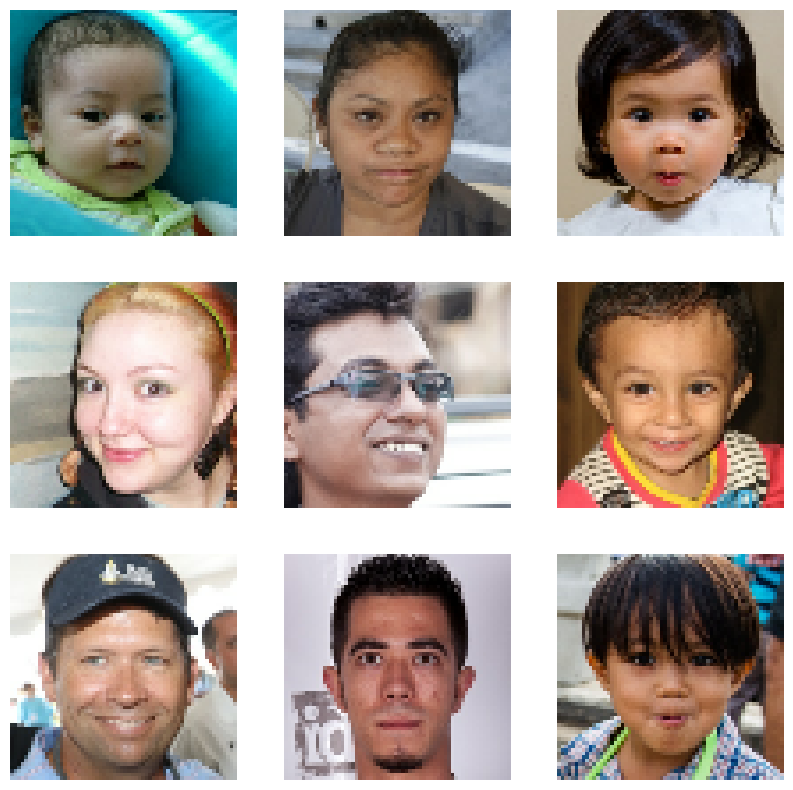

In [9]:
for batch in dataset.take(1):  # Take the first batch for display
    batch = (batch + 1) / 2
    plt.figure(figsize=(10, 10))
    for i in range(min(BATCH_SIZE, 9)):
        plt.subplot(3, 3, i + 1)
        plt.imshow(batch[i].numpy())
        plt.axis("off")
    plt.show()

In [10]:
len(dataset)

98

## GAN architecture

In [11]:
from keras.initializers import RandomNormal
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, Conv2DTranspose, BatchNormalization, ZeroPadding2D, UpSampling2D, Activation, MaxPooling2D

In [12]:
def build_generator():
    init = RandomNormal(stddev=0.02, seed=69)
    model = Sequential()

    model.add(Dense(2*2*512, input_dim=latent_features, kernel_initializer=init))
    # model.add(BatchNormalization())
    model.add(LeakyReLU(0.2))
    model.add(Reshape((2,2,512)))

    model.add(Conv2DTranspose(256, 4, 2,padding='same', kernel_initializer=init, use_bias=False))
    # model.add(BatchNormalization())
    model.add(LeakyReLU(0.2))

    model.add(Conv2DTranspose(128, 4, 2,padding='same', kernel_initializer=init, use_bias=False))
    # model.add(BatchNormalization())
    model.add(LeakyReLU(0.2))

    model.add(Conv2DTranspose(64, 4, 2,padding='same', kernel_initializer=init, use_bias=False))
    # model.add(BatchNormalization())
    model.add(LeakyReLU(0.2))

    model.add(Conv2DTranspose(32, 4, 2,padding='same', kernel_initializer=init, use_bias=False))
    # model.add(BatchNormalization())
    model.add(LeakyReLU(0.2))

    model.add(Conv2DTranspose(3, 4, 2,padding='same', activation='tanh', kernel_initializer=init, use_bias=False))

    return model

generator = build_generator()
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 2048)              206848    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 2048)              0         
                                                                 
 reshape (Reshape)           (None, 2, 2, 512)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 4, 4, 256)         2097152   
 anspose)                                                        
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 8, 8, 128)         524288    
 Transpose)                                             

2024-01-31 18:59:11.438288: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8906
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


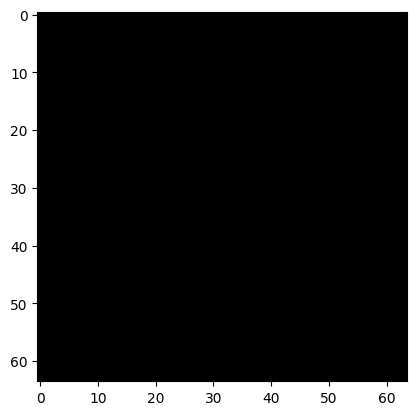

In [13]:
img = generator(np.random.normal(size=(1, latent_features, 1)))
plt.imshow(img[0])

In [14]:
def build_discriminator():
    init = RandomNormal(stddev=0.02, seed=69)
    model = Sequential()

    model.add(Conv2D(64, 4, 2, padding='same', input_shape = (image_width,image_height,3), kernel_initializer=init, use_bias=False))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, 4, 2, padding='same', kernel_initializer=init, use_bias=False))
    # model.add(BatchNormalization())
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.25))

    model.add(Conv2D(256, 4, 2, padding='same', kernel_initializer=init, use_bias=False))
    # model.add(BatchNormalization())
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.25))

    model.add(Conv2D(512, 4, 2, padding='same', kernel_initializer=init, use_bias=False))
    # model.add(BatchNormalization())
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.25))

    # model.add(Conv2D(1024, 4, 2, kernel_initializer=init, use_bias=False))
    # model.add(BatchNormalization())
    # model.add(LeakyReLU(0.2))
    # model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

discriminator = build_discriminator()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        3072      
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                                 
 dropout (Dropout)           (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       131072    
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 256)        

In [15]:
img = generator.predict(np.random.normal(size=(4, latent_features, 1)))
discriminator.predict(img)

1/1 [==============================] - 0s 433ms/step


array([[0.5000076 ],
       [0.50000614],
       [0.50000554],
       [0.50000775]], dtype=float32)

## Training loop

In [16]:
# from keras.models import load_model
# generator = load_model('models/generator_50epoch.keras')
# discriminator = load_model('models/discriminator_50epoch.keras')

In [17]:
from keras.models import Model
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy
from keras.utils import array_to_img
from keras.callbacks import Callback

In [18]:
class GAN(Model):
    def __init__(self, generator, discriminator, *args, **kwargs):
        # Pass through args and kwargs to base class
        super().__init__(*args, **kwargs)

        # Create attributes for gen and disc
        self.generator = generator
        self.discriminator = discriminator

    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs):
        # Compile with base class
        super().compile(*args, **kwargs)

        # Create attributes for losses and optimizers
        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss

    def train_step(self, batch):
        # Train the discriminator
        with tf.GradientTape() as d_tape:
            real_images = batch
            ypred_real = self.discriminator(real_images, training=True)
            y_real = tf.ones_like(ypred_real)
            # noise_real = -0.10*tf.random.uniform(tf.shape(ypred_real))
            # y_real += noise_real
            real_d_loss = self.d_loss(y_real, ypred_real)
        dgrad = d_tape.gradient(real_d_loss, self.discriminator.trainable_variables)
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))

        with tf.GradientTape() as d_tape:
            fake_images = self.generator(tf.random.normal((BATCH_SIZE, latent_features, 1)), training=False)
            ypred_fake = self.discriminator(fake_images, training=True)
            y_fake = tf.zeros_like(ypred_fake)
            # noise_fake = 0.10*tf.random.uniform(tf.shape(ypred_fake))
            # y_fake += noise_fake
            fake_d_loss = self.d_loss(y_fake, ypred_fake)

            total_d_loss = real_d_loss + fake_d_loss
        # Apply backpropagation - nn learn
        dgrad = d_tape.gradient(fake_d_loss, self.discriminator.trainable_variables)
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))

        # Train the generator
        with tf.GradientTape() as g_tape:
            gen_images = self.generator(tf.random.normal((BATCH_SIZE,latent_features,1)), training=True)
            predicted_labels = self.discriminator(gen_images, training=False)
            total_g_loss = self.g_loss(tf.ones_like(predicted_labels), predicted_labels)
        # Apply backprop
        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))

        return {"d_loss":total_d_loss, "g_loss":total_g_loss}

In [19]:
d_opt = Adam(learning_rate=0.0002,beta_1=0.5)
g_opt = Adam(learning_rate=0.0002,beta_1=0.5)
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

In [20]:
gan = GAN(generator, discriminator)
gan.compile(g_opt, d_opt, g_loss, d_loss)

In [21]:
class ModelMonitor(Callback):
    def __init__(self, latent_dim=latent_features):
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        if epoch % 5 == 0:
            random_latent_vectors = tf.random.uniform((1, self.latent_dim,1))
            generated_images = self.model.generator(random_latent_vectors)
            generated_images = (generated_images + 1) / 2
            generated_images = generated_images.numpy()
            img = array_to_img(generated_images[0])
            os.makedirs("training/", exist_ok=True)
            img.save(f'training/{epoch}_generated_img.png')
            generator.save('generator.keras')
            discriminator.save('discriminator.keras')


## Training

In [22]:
hist = gan.fit(dataset, epochs=50, callbacks=[ModelMonitor()])

Epoch 1/50


2024-01-31 18:59:30.022942: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-01-31 18:59:32.000162: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fe7943a7790 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-31 18:59:32.000197: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-01-31 18:59:32.009550: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1706727572.153945   52661 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


98/98 [==============================] - 12s 45ms/step - d_loss: 0.7222 - g_loss: 0.6999
Epoch 2/50
98/98 [==============================] - 3s 34ms/step - d_loss: 0.7028 - g_loss: 0.7161
Epoch 3/50
98/98 [==============================] - 3s 34ms/step - d_loss: 0.6841 - g_loss: 0.7302
Epoch 4/50
98/98 [==============================] - 3s 33ms/step - d_loss: 0.6750 - g_loss: 0.7432
Epoch 5/50
98/98 [==============================] - 3s 34ms/step - d_loss: 0.6545 - g_loss: 0.7562
Epoch 6/50
98/98 [==============================] - 4s 36ms/step - d_loss: 0.6407 - g_loss: 0.7719
Epoch 7/50
98/98 [==============================] - 3s 33ms/step - d_loss: 0.6295 - g_loss: 0.7846
Epoch 8/50
98/98 [==============================] - 3s 33ms/step - d_loss: 0.6129 - g_loss: 0.8007
Epoch 9/50
98/98 [==============================] - 3s 33ms/step - d_loss: 0.5999 - g_loss: 0.8112
Epoch 10/50
98/98 [==============================] - 3s 34ms/step - d_loss: 0.5934 - g_loss: 0.8306
Epoch 11/50
98/98 [

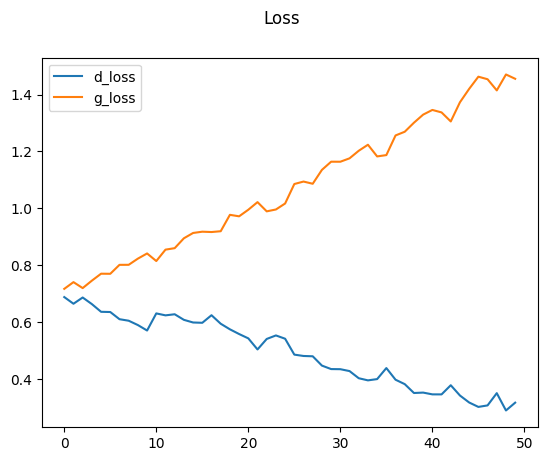

In [23]:
plt.suptitle('Loss')
plt.plot(hist.history['d_loss'], label='d_loss')
plt.plot(hist.history['g_loss'], label='g_loss')
plt.legend()
plt.show()

In [24]:
import os
from PIL import Image
import imageio

def create_gif(input_folder, output_gif_path, duration=0.2):
    images = []

    # Iterate through all files in the input folder
    for filename in sorted(os.listdir(input_folder)):
        if filename.endswith(('.png', '.jpg', '.jpeg')):
            file_path = os.path.join(input_folder, filename)

            # Open the image using PIL
            img = Image.open(file_path)
            images.append(img)

    # Save the images as a GIF using imageio
    imageio.mimsave(output_gif_path, images, duration=duration)

input_folder = "training/"
output_gif_path = "output.gif"

create_gif(input_folder, output_gif_path)

## Testing

1/1 [==============================] - 0s 175ms/step


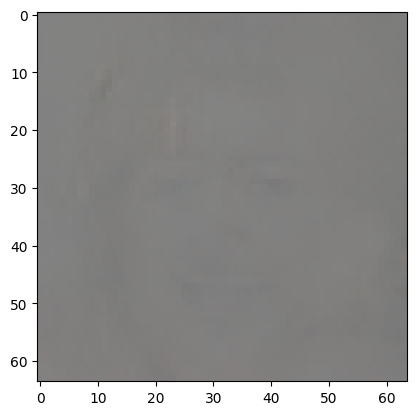

In [25]:
img = generator.predict(tf.random.normal((1, latent_features, 1)))
img = (img + 1) / 2
plt.imshow(img[0])